In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 
import sys


if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    

os.chdir(r'C:\Users\User\GitHub\WebET_Analysis')
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


In [2]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Read Data

In [3]:
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et.csv')
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

print(pd.DataFrame([[len(data_et)], [len(data_trial)], [len(data_subject)]], 
                   columns=['length'],
                   index=['data_et', 'data_trial', 'data_subject'])
     )

              length
data_et       725392
data_trial     35796
data_subject      92


# Create datasets

## data_trial_choice

In [4]:
data_trial_choice = data_trial.loc[
    data_trial['trial_type']=='eyetracking-choice', 
    [
        'run_id', 'chinFirst', 
        'task_nr', 
        'trial_index', 'trial_type', 'withinTaskIndex', 
        'choiceTask_amountLeftFirst', 
        'option_topLeft', 'option_bottomLeft',
        'option_topRight', 'option_bottomRight',
        'key_press', 'trial_duration_exact',
        'window_width', 'window_height',
        'fps'
    ]
]

## data_et_choice

In [5]:
def add_var_to_data_et(data_et, source_data, varName):
    if varName in data_et.columns: data_et=data_et.drop(columns=varName)
    data_et = data_et.merge(
        source_data.loc[:, ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    return data_et

data_et = add_var_to_data_et(data_et, data_trial, 'trial_type')
data_et = add_var_to_data_et(data_et, data_trial, 'withinTaskIndex')

data_et_choice = data_et \
    .loc[data_et['trial_type']=='eyetracking-choice', :] \
    .drop(columns=['trial_type'])
data_et_choice

,x,y,t,t_task,run_id,trial_index,withinTaskIndex
607,0.627605,0.429164,509546.610,0.000,1.0,145.0,1.0
608,0.604833,0.425830,510013.380,466.770,1.0,145.0,1.0
609,0.622740,0.387974,510486.345,939.735,1.0,145.0,1.0
610,0.592737,0.415015,510958.065,1411.455,1.0,145.0,1.0
611,0.498632,0.300594,511430.640,1884.030,1.0,145.0,1.0
...,...,...,...,...,...,...,...
725387,0.598366,0.533074,2042687.995,0.000,97.0,508.0,80.0
725388,0.570146,0.484565,2043483.220,795.225,97.0,508.0,80.0
725389,0.500049,0.481787,2044286.395,1598.400,97.0,508.0,80.0
725390,0.559069,0.542302,2045104.035,2416.040,97.0,508.0,80.0


# Screening

## Visually impaired without aids? 

In [6]:
subjects_cannotSee = data_subject.loc[
    (data_subject['sight'] == 'notCorrected') & 
    (data_subject['glasses'] == 'longSight'),
    'run_id']
subjects_cannotSee

48    28
Name: run_id, dtype: int64

## Not enough trials

In [7]:
def merge_max_var_by_index(data, data_subject, varName, newName):
    grouped = data \
        .groupby(['run_id'])[varName].max() \
        .reset_index() \
        .rename(columns={varName: newName})
    if newName in data_subject.columns:
        data_subject = data_subject.drop(columns=[newName])
    data_subject = data_subject.merge(
        grouped, 
        on='run_id',
        how='left'
    )
    return data_subject

data_subject = merge_max_var_by_index(
    data_trial_choice, 
    data_subject, 
    'withinTaskIndex', 
    'max_choiceIndex'
)

data_subject = merge_max_var_by_index(
    data_trial, 
    data_subject, 
    'trial_index', 
    'max_trial_index'
)
data_subject.loc[
    data_subject['max_choiceIndex']!=80,
    ['run_id', 'max_trial_index', 'max_choiceIndex']
].sort_values(by='run_id')

,run_id,max_trial_index,max_choiceIndex
13,14,NaN,NaN
61,49,NaN,NaN
63,54,NaN,NaN
68,61,271.0,42.0
74,72,NaN,NaN
79,83,NaN,NaN
81,88,NaN,NaN
91,99,NaN,NaN
2,106,NaN,NaN
3,108,NaN,NaN


In [8]:
subjects_not_enough_trials = data_subject.loc[
    pd.isna(data_subject['max_choiceIndex']) |
    (data_subject['max_choiceIndex']<40),
    'run_id'
]
subjects_not_enough_trials

2     106
3     108
6     124
7     125
13     14
14    141
17    147
18    148
19    149
25    156
28    161
29    162
34    168
36    172
37    173
40    178
43    181
61     49
63     54
74     72
79     83
81     88
91     99
Name: run_id, dtype: int64

## Did not keep head still

In [9]:
data_subject.loc[
    data_subject['keptHead']==0, 
    ['run_id', 'prolificID', 'keptHead']
]

,run_id,prolificID,keptHead


In [10]:
subjects_not_kept_head = data_subject.loc[
    data_subject['keptHead']==0, 'run_id']

## Not approved on Prolific

In [11]:
data_subject.loc[
    ~data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC']),
    :
]

,run_id,birthyear,browliner,browser,browser_version,degree,device,ethnic,eyeliner,eyeshadow,...,Current Country of Residence,Employment Status,First Language,Nationality,Sex,Student Status,Webcam,fps,max_choiceIndex,max_trial_index
15,144,1997.0,0.0,Safari,14.0.3,college,Macintosh,caucasian,0.0,0.0,...,United States,Part-Time,English,United States,Female,Yes,Yes,17.503355,80.0,537.0
16,146,1997.0,0.0,Chrome,88.0.4324.150,college,Macintosh,asian,0.0,0.0,...,United States,Other,NaN,India,Female,Yes,Yes,17.295826,80.0,536.0
20,150,1991.0,0.0,Chrome,88.0.4324.150,grad,WebKit,asian,1.0,0.0,...,United States,Full-Time,Bengali,Bangladesh,Female,No,Yes,20.021312,80.0,537.0
21,151,1996.0,0.0,Chrome,88.0.4324.150,college,WebKit,asian,0.0,0.0,...,United States,DATA EXPIRED,Nepali,Nepal,Female,Yes,Yes,8.051746,80.0,536.0
22,152,1998.0,0.0,Chrome,87.0.4280.141,college,Macintosh,caucasian,0.0,0.0,...,United States,Part-Time,DATA EXPIRED,United States,Female,Yes,Yes,14.911969,80.0,538.0
23,153,1958.0,0.0,Chrome,88.0.4324.153,high,WebKit,asian,0.0,0.0,...,United States,"Not in paid work (e.g. homemaker', 'retired or...",DATA EXPIRED,Bangladesh,Male,No,Yes,5.873565,80.0,537.0
24,154,1980.0,0.0,Chrome,88.0.4324.150,college,WebKit,asian,0.0,0.0,...,United States,Full-Time,NaN,India,Male,No,Yes,20.279893,80.0,536.0
26,157,1993.0,0.0,Chrome,88.0.4324.150,NaN,WebKit,caucasian,0.0,0.0,...,United States,Other,NaN,United States,Female,Yes,Yes,7.982667,80.0,536.0
27,160,1946.0,0.0,Chrome,88.0.4324.146,college,WebKit,caucasian,0.0,0.0,...,United States,"Not in paid work (e.g. homemaker', 'retired or...",Dutch,Netherlands,Male,No,Yes,23.642608,80.0,536.0
29,162,NaN,NaN,Firefox,85.0,NaN,NaN,NaN,NaN,NaN,...,United States,Full-Time,DATA EXPIRED,Italy,Male,Yes,Yes,15.858163,NaN,131.0


In [12]:
subjects_notApproved = data_subject.loc[
    ~data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC']),
    'run_id'
]
subjects_notApproved

15    144
16    146
20    150
21    151
22    152
23    153
24    154
26    157
27    160
29    162
30    163
31    164
32    165
33    166
35    171
38    176
39    177
41    179
42    180
Name: run_id, dtype: int64

## Reaction time

## Reaction time / Trials too long

In [13]:
data_trial_choice.loc[data_trial_choice['trial_duration_exact']>10000, :]
print(len(data_trial_choice.loc[
    data_trial_choice['trial_duration_exact']>10000, 
    'run_id'
].unique()))

12


In [14]:
print(
    'Average reaction time raw: ' +
    str(data_trial_choice['trial_duration_exact'].mean()) +
    '\n SD=' +
    str(data_trial_choice['trial_duration_exact'].std()) 
)

print(
    'Average reaction time below 10 seconds: ' +
    str(data_trial_choice.loc[
        data_trial_choice['trial_duration_exact']<10000, 
        'trial_duration_exact'].mean()) +
    '\n SD=' +
    str(data_trial_choice.loc[
        data_trial_choice['trial_duration_exact']<10000, 
        'trial_duration_exact'].std()) 
)

Average reaction time raw: 2502.9775941230487
 SD=2649.1621042796482
Average reaction time below 10 seconds: 2241.072271110279
 SD=1284.230273850463


## Not enough fps

In [15]:
grouped = data_et_choice \
    .groupby(['run_id', 'trial_index'])['x'].count() \
    .reset_index() \
    .rename(columns={'x': 'x_count'})
if 'x_count' in data_trial_choice.columns:
    data_trial_choice = data_trial_choice.drop(columns=['x_count'])
data_trial_choice = data_trial_choice \
    .merge(grouped, on=['run_id', 'trial_index'], how='left')
print(data_trial_choice.columns)
data_trial_choice['fps_choice']= \
    1000 * data_trial_choice['x_count'] / \
    data_trial_choice['trial_duration_exact']
data_trial_choice['fps_choice'].describe()

Index(['run_id', 'chinFirst', 'task_nr', 'trial_index', 'trial_type',
       'withinTaskIndex', 'choiceTask_amountLeftFirst', 'option_topLeft',
       'option_bottomLeft', 'option_topRight', 'option_bottomRight',
       'key_press', 'trial_duration_exact', 'window_width', 'window_height',
       'fps', 'x_count'],
      dtype='object')


count    5031.000000
mean       16.710301
std         8.601624
min         0.072031
25%        10.434312
50%        17.132552
75%        22.198979
max        35.980991
Name: fps_choice, dtype: float64

In [16]:
print(data_trial_choice.loc[
    data_trial_choice['fps_choice']<3, 
    'run_id'].unique())

grouped = data_trial_choice \
    .loc[
        data_trial_choice['fps_choice']<1, 
        ['run_id', 'trial_index', 'fps_choice']
    ] \
    .groupby(['run_id'])['trial_index'].count() \
    .reset_index() \
    .rename(columns={'trial_index': 'n_lowFPS'})
print(grouped)
subjects_lowFPS = grouped.loc[
    grouped['n_lowFPS'] > 10, 
    'run_id'
]
subjects_lowFPS

[  1 163 183   4  70  80   9  94  97]
   run_id  n_lowFPS
0       9        12
1      70        80
2      94         3
3     183        43


0      9
1     70
3    183
Name: run_id, dtype: int64

# Cleaning

In [17]:
excludedSubjects = list(
    set(subjects_not_enough_trials) | 
    set(subjects_not_kept_head) |
    set(subjects_notApproved) |
    set(subjects_lowFPS) |
    set(subjects_cannotSee)
)

if not os.path.exists('./data_jupyter'):
    os.mkdir('./data_jupyter')
pd.DataFrame(excludedSubjects) \
    .to_csv("data_jupyter/excludeSubjects_choice.csv", index=False, header=False)

excludedSubjects

[9,
 141,
 14,
 144,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 156,
 157,
 28,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 168,
 171,
 172,
 173,
 176,
 49,
 178,
 177,
 179,
 181,
 54,
 180,
 183,
 70,
 72,
 83,
 88,
 99,
 106,
 108,
 124,
 125]

## data_trial_choice

In [18]:
def cleanTrialData(data):
    print('Raw: ' + str(len(data)))
    data = data.loc[
        ~(data['run_id'].isin(excludedSubjects)) &
        (data['trial_duration_exact']<10000), 
        :]
    print('Cleaned: ' + str(len(data)))
    return data

data_trial_choice = cleanTrialData(data_trial_choice)

Raw: 5445
Cleaned: 3707


## data_et_choice

In [19]:
def cleanETData(data):
    print('Raw: ' + str(len(data)))
    data = data.loc[
        (data['x'] > 0) & (data['x'] < 1) &
        (data['y'] > 0) & (data['y'] < 1) &
        ~(data['run_id'].isin(excludedSubjects)) &
        (data['t_task']<10000), 
        :]
    print('Cleaned: ' + str(len(data)))
    return data

data_et_choice = cleanETData(data_et_choice)

Raw: 176949
Cleaned: 122034


# Choice options

## Choice attributes

In [20]:
def identify_amount_left(data):
    data['amountLeft'] = 0 
    data.loc[
        (data['option_topLeft'].str.contains("\$", regex=True)) |
        (data['option_topLeft'].str.contains("cent", regex=True)), 
        'amountLeft'] = 1
    data['amountLeft'].unique()
    return data

data_trial_choice = identify_amount_left(data_trial_choice)
data_trial_choice.loc[:, ['amountLeft', 'option_topLeft']]

,amountLeft,option_topLeft
0,0,30 days
1,0,30 days
2,0,Today
3,0,180 days
4,0,15 days
...,...,...
5440,1,50 cent
5441,1,$2.5
5442,1,$2
5443,1,$4.5


In [21]:
data_et_choice = add_var_to_data_et(data_et_choice, data_trial_choice, 'amountLeft')

In [22]:
def choice_options_to_numeric(data, varName): 
    data[varName + '_num'] = data[varName]
    data[varName + '_num'] = data[varName + '_num'] \
        .replace(['Today', 'Tomorrow', '7 days', 
                  '15 days', '30 days', '90 days', 
                  '180 days'], 
                 [0, 1, 7, 15, 30, 90, 180]) \
        .replace({'\$':''}, regex = True) \
        .replace('50 cent', 0.5) \
        .astype(float)
    return data

data_trial_choice = data_trial_choice \
    .rename(columns={
    'option_topLeft': 'option_TL', 
    'option_bottomLeft': 'option_BL', 
    'option_topRight': 'option_TR', 
    'option_bottomRight': 'option_BR'
    })

variables = [
    'option_TL',
    'option_BL', 
    'option_TR', 
    'option_BR'
]
for var in variables:
    data_trial_choice = choice_options_to_numeric(data_trial_choice, var) 
    
data_trial_choice.loc[
    :, 
    [
    'option_TL',
    'option_BL', 
    'option_TR', 
    'option_BR',
    'option_TL_num',
    'option_BL_num', 
    'option_TR_num', 
    'option_BR_num'
    ]
]

,option_TL,option_BL,option_TR,option_BR,option_TL_num,option_BL_num,option_TR_num,option_BR_num
0,30 days,Today,$4,$3,30.0,0.0,4.0,3.0
1,30 days,Today,$5,$3.5,30.0,0.0,5.0,3.5
2,Today,180 days,$2.5,$5,0.0,180.0,2.5,5.0
3,180 days,Today,$4.5,$4,180.0,0.0,4.5,4.0
4,15 days,Today,$4.5,$4,15.0,0.0,4.5,4.0
...,...,...,...,...,...,...,...,...
5440,50 cent,$4.5,Today,30 days,0.5,4.5,0.0,30.0
5441,$2.5,$5,Today,30 days,2.5,5.0,0.0,30.0
5442,$2,$5,Today,7 days,2.0,5.0,0.0,7.0
5443,$4.5,50 cent,90 days,Today,4.5,0.5,90.0,0.0


In [23]:
def reformatAttributes(data):    
    data['aSS'] = 0 
    data.loc[data['amountLeft']==1, 'aSS']= \
        data.loc[
            data['amountLeft']==1, 
            ["option_TL_num", "option_BL_num"]
        ].values.min(1)
    data.loc[data['amountLeft']==0, 'aSS']= \
        data.loc[
            data['amountLeft']==0, 
            ["option_TR_num", "option_BR_num"]
        ].values.min(1)

    data['aLL'] = 0 
    data.loc[data['amountLeft']==1, 'aLL']= \
        data.loc[
            data['amountLeft']==1, 
            ["option_TL_num", "option_BL_num"]
        ].values.max(1)
    data.loc[data['amountLeft']==0, 'aLL']= \
        data.loc[
            data['amountLeft']==0, 
            ["option_TR_num", "option_BR_num"]
        ].values.max(1)
    
    data.loc[:, "tSS"] = 0 
    
    data['tLL'] = 0 
    data.loc[data['amountLeft']==1, 'tLL']= \
        data.loc[
            data['amountLeft']==1, 
            ["option_TR_num", "option_BR_num"]
        ].values.max(1)
    data.loc[data['amountLeft']==0, 'tLL']= \
        data.loc[
            data['amountLeft']==0, 
            ["option_TL_num", "option_BL_num"]
        ].values.max(1)
    
    data['LL_top'] = \
        (data["option_TL_num"] > data["option_BL_num"]) \
        .astype(int)

    print('aLL values: ' + str(np.sort(data['aLL'].unique())))
    print('aSS values: ' + str(np.sort(data['aSS'].unique())))
    print('tLL values: ' + str(np.sort(data['tLL'].unique())))
    print('tSS values: ' + str(np.sort(data['tSS'].unique())))
    
    return data

data_trial_choice = reformatAttributes(data_trial_choice)
data_trial_choice.loc[
    : , 
    [
        'amountLeft', 
        'option_TL',
        'option_BL', 
        'option_TR', 
        'option_BR', 
        'aLL', 
        'aSS', 
        'tLL', 
        'tSS',
        'LL_top'
    ] 
]

aLL values: [4.  4.5 5. ]
aSS values: [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5]
tLL values: [  1.   7.  15.  30.  90. 180.]
tSS values: [0]


,amountLeft,option_TL,option_BL,option_TR,option_BR,aLL,aSS,tLL,tSS,LL_top
0,0,30 days,Today,$4,$3,4.0,3.0,30.0,0,1
1,0,30 days,Today,$5,$3.5,5.0,3.5,30.0,0,1
2,0,Today,180 days,$2.5,$5,5.0,2.5,180.0,0,0
3,0,180 days,Today,$4.5,$4,4.5,4.0,180.0,0,1
4,0,15 days,Today,$4.5,$4,4.5,4.0,15.0,0,1
...,...,...,...,...,...,...,...,...,...,...
5440,1,50 cent,$4.5,Today,30 days,4.5,0.5,30.0,0,0
5441,1,$2.5,$5,Today,30 days,5.0,2.5,30.0,0,0
5442,1,$2,$5,Today,7 days,5.0,2.0,7.0,0,0
5443,1,$4.5,50 cent,90 days,Today,4.5,0.5,90.0,0,1


In [24]:
def top_bottom_attributes(data):
    data['aT'] = data['LL_top'] * data['aLL'] + \
        (1-data['LL_top']) * data['aSS']
    data['aB'] = (1-data['LL_top']) * data['aLL'] + \
        data['LL_top'] * data['aSS']
    data['tT'] = data['LL_top'] * data['tLL'] + \
        (1-data['LL_top']) * data['tSS']
    data['tB'] = (1-data['LL_top']) * data['tLL'] + \
        data['LL_top'] * data['tSS']
    
    return(data)

data_trial_choice = top_bottom_attributes(data_trial_choice)
data_trial_choice.loc[
    :, 
    ['aT', 'tT', 'aB', 'tB', 'LL_top']
].sort_values(by='LL_top')

,aT,tT,aB,tB,LL_top
4823,4.0,0.0,5.0,30.0,0
2866,1.0,0.0,4.0,15.0,0
4713,4.0,0.0,4.5,1.0,0
4714,2.0,0.0,4.0,15.0,0
2863,3.5,0.0,4.5,7.0,0
...,...,...,...,...,...
3247,4.5,90.0,2.0,0.0,1
3248,4.0,90.0,3.0,0.0,1
3249,5.0,90.0,3.0,0.0,1
3241,4.5,30.0,2.0,0.0,1


In [25]:
data_et_choice = add_var_to_data_et(
    data_et_choice, 
    data_trial_choice, 
    'LL_top'
)

## Behavioral response variables

In [26]:
def choice_response_variables(data):
    
    # Up-Arrow is 38, Down-Arrow is 40
    data["choseTop"] = 0
    data.loc[(data["key_press"]==38), "choseTop"] = 1

    data["choseLL"] = 0
    data.loc[(data["choseTop"]==1) & (data["LL_top"] == 1), "choseLL"] = 1
    data.loc[(data["choseTop"]==0) & (data["LL_top"] == 0), "choseLL"] = 1
    
    return(data)

data_trial_choice = choice_response_variables(data_trial_choice)

# Check these subjects:  19   32   66   96  126  130 1000 2012
data_trial_choice.loc[
    :, # data_trial_choice['run_id']==32, 
    [
        'amountLeft', 
        'option_TL',
        'option_TR', 
        'option_BL', 
        'option_BR', 
        'key_press',
        'choseTop',
        'choseLL', 
        ]
].sort_values(by='amountLeft')

,amountLeft,option_TL,option_TR,option_BL,option_BR,key_press,choseTop,choseLL
0,0,30 days,$4,Today,$3,38.0,1,1
3134,0,30 days,$4,Today,$3.5,40.0,0,0
3133,0,Today,$1,90 days,$4.5,40.0,0,1
3132,0,Today,$1,30 days,$4,40.0,0,1
3131,0,Today,$3.5,180 days,$4.5,38.0,1,0
...,...,...,...,...,...,...,...,...
3230,1,$4,30 days,$1.5,Today,38.0,1,1
3231,1,$4,180 days,50 cent,Today,38.0,1,1
3232,1,50 cent,Today,$4,30 days,40.0,0,1
3225,1,$5,30 days,$1,Today,38.0,1,1


In [27]:
data_trial_choice.loc[
    (data_trial_choice['choseTop']==1) &
    (data_trial_choice['LL_top']==1)
    ,
    [
        'amountLeft', 
        'option_TL',
        'option_TR', 
        'option_BL', 
        'option_BR',
        'key_press',
        'choseLL'
    ]
].sort_values(by='amountLeft')

,amountLeft,option_TL,option_TR,option_BL,option_BR,key_press,choseLL
0,0,30 days,$4,Today,$3,38.0,1
3702,0,Tomorrow,$4,Today,$3,38.0,1
3703,0,90 days,$5,Today,$1,38.0,1
3704,0,7 days,$4,Today,$3,38.0,1
3715,0,30 days,$4,Today,$2.5,38.0,1
...,...,...,...,...,...,...,...
3983,1,$5,30 days,$2,Today,38.0,1
3985,1,$5,15 days,$1.5,Today,38.0,1
3993,1,$5,7 days,$3.5,Today,38.0,1
640,1,$4.5,15 days,$1.5,Today,38.0,1


## Aggregate on subject level

In [28]:
def merge_by_subject(data, large_data, varName):
    if varName in data.columns: data = data.drop(columns=[varName])
    grouped = large_data.groupby(['run_id'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id'], how='left')
    return data
print(data_subject.columns)
for var in ['choseLL', 'choseTop', 'LL_top']:
    data_subject = merge_by_subject(data_subject, data_trial_choice, var)
#data_subject.loc[
#    ~data_subject['run_id'].isin(excludedSubjects),
#    ['run_id', 'choseLL', 'choseTop', 'LL_top']
#]

Index(['run_id', 'birthyear', 'browliner', 'browser', 'browser_version',
       'degree', 'device', 'ethnic', 'eyeliner', 'eyeshadow', 'gender',
       'glasses', 'keptHead', 'masquara', 'optionalNote', 'platform',
       'platform_version', 'sight', 'triedChin', 'user_agent', 'vertPosition',
       'webcam_fps', 'webcam_height', 'webcam_label', 'webcam_width',
       'chosenAmount', 'chosenDelay', 'chinFirst',
       'choiceTask_amountLeftFirst', 'prolificID', 'session_id', 'status',
       'started_datetime', 'completed_date_time', 'time_taken', 'age',
       'num_approvals', 'num_rejections', 'prolific_score',
       'reviewed_at_datetime', 'entered_code', 'Country of Birth',
       'Current Country of Residence', 'Employment Status', 'First Language',
       'Nationality', 'Sex', 'Student Status', 'Webcam', 'fps',
       'max_choiceIndex', 'max_trial_index'],
      dtype='object')


# k

In [29]:
def k(aLL, aSS, tLL):
    k = ((aLL / aSS) - 1) / tLL
    return k

data_trial_choice['k'] = k(data_trial_choice['aLL'], data_trial_choice['aSS'], data_trial_choice['tLL']) 
data_trial_choice

,run_id,chinFirst,task_nr,trial_index,trial_type,withinTaskIndex,choiceTask_amountLeftFirst,option_TL,option_BL,option_TR,...,tSS,tLL,LL_top,aT,aB,tT,tB,choseTop,choseLL,k
0,1,1.0,2.0,145.0,eyetracking-choice,1.0,0.0,30 days,Today,$4,...,0,30.0,1,4.0,3.0,30.0,0.0,1,1,0.011111
1,1,1.0,2.0,148.0,eyetracking-choice,2.0,0.0,30 days,Today,$5,...,0,30.0,1,5.0,3.5,30.0,0.0,1,1,0.014286
2,1,1.0,2.0,151.0,eyetracking-choice,3.0,0.0,Today,180 days,$2.5,...,0,180.0,0,2.5,5.0,0.0,180.0,0,1,0.005556
3,1,1.0,2.0,154.0,eyetracking-choice,4.0,0.0,180 days,Today,$4.5,...,0,180.0,1,4.5,4.0,180.0,0.0,0,0,0.000694
4,1,1.0,2.0,157.0,eyetracking-choice,5.0,0.0,15 days,Today,$4.5,...,0,15.0,1,4.5,4.0,15.0,0.0,0,0,0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5440,98,0.0,3.0,496.0,eyetracking-choice,76.0,0.0,50 cent,$4.5,Today,...,0,30.0,0,0.5,4.5,0.0,30.0,0,1,0.266667
5441,98,0.0,3.0,499.0,eyetracking-choice,77.0,0.0,$2.5,$5,Today,...,0,30.0,0,2.5,5.0,0.0,30.0,0,1,0.033333
5442,98,0.0,3.0,502.0,eyetracking-choice,78.0,0.0,$2,$5,Today,...,0,7.0,0,2.0,5.0,0.0,7.0,0,1,0.214286
5443,98,0.0,3.0,505.0,eyetracking-choice,79.0,0.0,$4.5,50 cent,90 days,...,0,90.0,1,4.5,0.5,90.0,0.0,1,1,0.088889


# Look direction

In [30]:
def lookDirections(data):
    data["look_left"] = (data["x"] < 0.5).astype(int)
    data["look_top"] = (data["y"] < 0.5).astype(int)
    return data

data_et_choice = lookDirections(data_et_choice)

# AOIs

In [31]:
def addAOI(data): 
    aoiCenters = pd.DataFrame(
        [
            [(0.05+0.9*0.2), 0.25],
            [(0.05+0.9*0.8), 0.25],
            [(0.05+0.9*0.2), 0.75],
            [(0.05+0.9*0.8), 0.75]
        ], 
        columns = ['x', 'y'],
        index = ['TL', 'TR', 'BL', 'BR']
    )
    
    data['aoi'] = 0 
    for aoi in aoiCenters.index:
        data.loc[
            (
                (data['x'] > (aoiCenters.loc[aoi, 'x'] - 0.175)) & \
                (data['x'] < (aoiCenters.loc[aoi, 'x'] + 0.175)) & \
                (data['y'] > (aoiCenters.loc[aoi, 'y'] - 0.175)) & \
                (data['y'] < (aoiCenters.loc[aoi, 'y'] + 0.175))
             ), 'aoi'] = aoi
    return data 

data_et_choice = addAOI(data_et_choice)
data_et_choice['aoi'].unique()

array([0, 'TR', 'TL', 'BR', 'BL'], dtype=object)

In [32]:
def createAOIColumns(data):
    data['aoi_aLL'] = 0
    data['aoi_tLL'] = 0 
    data['aoi_aSS'] = 0 
    data['aoi_tSS'] = 0
    
    # If amounts are on the left side
    ## If the gaze point is in the top option
    data.loc[((data['amountLeft']==1) & (data['LL_top']==1) & (data['aoi']=='TL')), 
             'aoi_aLL'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==1) & (data['aoi']=='TR')), 
             'aoi_tLL'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==1) & (data['aoi']=='BL')), 
             'aoi_aSS'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==1) & (data['aoi']=='BR')), 
             'aoi_tSS'] = 1
    
    ## If the gaze point is in the bottom option
    data.loc[((data['amountLeft']==1) & (data['LL_top']==0) & (data['aoi']=='TL')), 
             'aoi_aSS'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==0) & (data['aoi']=='TR')), 
             'aoi_tSS'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==0) & (data['aoi']=='BL')), 
             'aoi_aLL'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==0) & (data['aoi']=='BR')), 
             'aoi_tLL'] = 1
    
    # If amounts are on the right side
    ## If the gaze point is in the top option
    data.loc[((data['amountLeft']==0) & (data['LL_top']==1) & (data['aoi']=='TL')), 
             'aoi_tLL'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==1) & (data['aoi']=='TR')), 
             'aoi_aLL'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==1) & (data['aoi']=='BL')), 
             'aoi_tSS'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==1) & (data['aoi']=='BR')),
             'aoi_aSS'] = 1

    ## If the gaze point is in the bottom option
    data.loc[((data['amountLeft']==0) & (data['LL_top']==0) & (data['aoi']=='TL')), 
             'aoi_tSS'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==0) & (data['aoi']=='TR')), 
             'aoi_aSS'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==0) & (data['aoi']=='BL')), 
             'aoi_tLL'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==0) & (data['aoi']=='BR')), 
             'aoi_aLL'] = 1
    return data

data_et_choice = createAOIColumns(data_et_choice)

# Eye-Tracking indices

## Add AOI counts

      run_id  trial_index  aoi_aSS  aoi_aLL  aoi_tSS  aoi_tLL
0        1.0        145.0        0        1        0        1
1        1.0        148.0        0        0        0        0
2        1.0        151.0        0        0        0        0
3        1.0        154.0        0        0        0        0
4        1.0        157.0        0        0        0        0
...      ...          ...      ...      ...      ...      ...
3271   131.0        496.0        2        0        1        0
3272   131.0        499.0        5        0        0        0
3273   131.0        502.0        4        0        0        0
3274   131.0        505.0        0        5        0        1
3275   131.0        508.0        0       10        0        0

[3276 rows x 6 columns]


<ipython-input-33-ad184f7a7842>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data_et_choice.groupby(['run_id', 'trial_index']) \


(array([8.525e+03, 1.997e+03, 1.238e+03, 5.260e+02, 3.280e+02, 1.620e+02,
        1.560e+02, 6.800e+01, 4.500e+01, 1.300e+01, 1.300e+01, 1.800e+01,
        4.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00]),
 array([ 0.  ,  4.45,  8.9 , 13.35, 17.8 , 22.25, 26.7 , 31.15, 35.6 ,
        40.05, 44.5 , 48.95, 53.4 , 57.85, 62.3 , 66.75, 71.2 , 75.65,
        80.1 , 84.55, 89.  ]),
 <BarContainer object of 20 artists>)

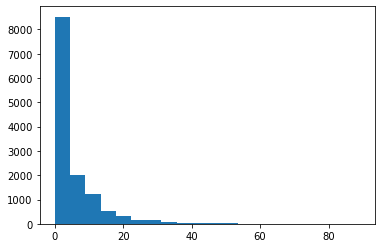

In [33]:
grouped = data_et_choice.groupby(['run_id', 'trial_index']) \
        ['aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL'].sum() \
        .reset_index() 
print(grouped)

data_plot = pd.DataFrame(pd.concat(
    [
        grouped['aoi_aSS'],
        grouped['aoi_tSS'],
        grouped['aoi_aLL'],
        grouped['aoi_tLL']
    ]), columns=['n']) 

plt.hist(data_plot, bins=20)

In [34]:
for var in ['aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL']:
    if var in data_trial_choice.columns: 
        data_trial_choice = data_trial_choice.drop(columns=[var])
        
data_trial_choice = data_trial_choice.merge(
    grouped, 
    on=['run_id', 'trial_index'], 
    how='left')
    
data_trial_choice.loc[
    :, 
    ['run_id', 'trial_index', 'aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL']
]

,run_id,trial_index,aoi_aSS,aoi_aLL,aoi_tSS,aoi_tLL
0,1,145.0,0.0,1.0,0.0,1.0
1,1,148.0,0.0,0.0,0.0,0.0
2,1,151.0,0.0,0.0,0.0,0.0
3,1,154.0,0.0,0.0,0.0,0.0
4,1,157.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
3702,98,496.0,NaN,NaN,NaN,NaN
3703,98,499.0,NaN,NaN,NaN,NaN
3704,98,502.0,NaN,NaN,NaN,NaN
3705,98,505.0,NaN,NaN,NaN,NaN


##  Option Index

In [35]:
def require_min(data, min_required_count):
    return data.replace(
        np.arange(min_required_count), 
        np.repeat(0, min_required_count)) 

def addOptionIndex(data):
    
    gazePoints_immediate = \
        require_min(data['aoi_aSS'], 3) + \
        require_min(data['aoi_tSS'], 3)
    gazePoints_delay = \
        require_min(data['aoi_aLL'], 3) + \
        require_min(data['aoi_tLL'], 3)
    optionIndex = \
        (gazePoints_immediate - gazePoints_delay) / \
        (gazePoints_immediate + gazePoints_delay)
    
    return optionIndex

data_trial_choice['optionIndex'] = addOptionIndex(data_trial_choice)
print(data_trial_choice['optionIndex'].describe())
print(
    pd.DataFrame(
        [
            [sum(pd.isna(data_trial_choice['optionIndex']))],
            [sum(data_trial_choice['optionIndex']==1)],
            [sum(data_trial_choice['optionIndex']==0)],
            [sum((data_trial_choice['optionIndex']>0) &
                 (data_trial_choice['optionIndex']<1))],
            [len(data_trial_choice)]
        ], index = ['NAN', '1', '0', '0>optionIndex>1', 'total']    
    )
)

print(data_trial_choice.loc[:, ['run_id', 'trial_index', 
                          'aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL', 
                          'optionIndex']])
print(data_trial_choice.loc[
    ~data_trial_choice['optionIndex'].isin([-1, 1]) &
    pd.notna(data_trial_choice['optionIndex']), 
    ['run_id', 'trial_index', 
     'aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL', 
     'optionIndex']])

count    2767.000000
mean       -0.046947
std         0.775854
min        -1.000000
25%        -1.000000
50%        -0.100000
75%         1.000000
max         1.000000
Name: optionIndex, dtype: float64
                    0
NAN               940
1                 698
0                  53
0>optionIndex>1   550
total            3707
      run_id  trial_index  aoi_aSS  aoi_aLL  aoi_tSS  aoi_tLL  optionIndex
0          1        145.0      0.0      1.0      0.0      1.0          NaN
1          1        148.0      0.0      0.0      0.0      0.0          NaN
2          1        151.0      0.0      0.0      0.0      0.0          NaN
3          1        154.0      0.0      0.0      0.0      0.0          NaN
4          1        157.0      0.0      0.0      0.0      0.0          NaN
...      ...          ...      ...      ...      ...      ...          ...
3702      98        496.0      NaN      NaN      NaN      NaN          NaN
3703      98        499.0      NaN      NaN      NaN      NaN     

## Attribute Index

In [36]:
def addAttributeIndex(data):

    gazePoints_amount = \
        require_min(data['aoi_aLL'], 3) + \
        require_min(data['aoi_aSS'], 3)
    gazePoints_time = \
        require_min(data['aoi_tLL'], 3) + \
        require_min(data['aoi_tSS'], 3)

    attributeIndex = \
        (gazePoints_amount - gazePoints_time) / \
        (gazePoints_amount + gazePoints_time)
    
    return attributeIndex


data_trial_choice['attributeIndex'] = addAttributeIndex(data_trial_choice)

print(data_trial_choice['attributeIndex'].describe())
print(pd.DataFrame(
        [
            [sum(pd.isna(data_trial_choice['attributeIndex']))],
            [sum(data_trial_choice['attributeIndex']==1)],
            [sum(data_trial_choice['attributeIndex']==0)],
            [sum((data_trial_choice['attributeIndex']>0) &
                 (data_trial_choice['attributeIndex']<1))],
            [len(data_trial_choice)]
        ], index = ['NAN', '1', '0', '0>attributeIndex>1', 'total']    
    )
)

print(data_trial_choice.loc[:, ['run_id', 'trial_index', 
                          'aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL', 
                          'attributeIndex']])
print(data_trial_choice.loc[
    ~data_trial_choice['attributeIndex'].isin([-1, 1]) &
    pd.notna(data_trial_choice['attributeIndex']), 
    ['run_id', 'trial_index', 
     'aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL', 
     'attributeIndex']])

count    2767.000000
mean        0.172552
std         0.714934
min        -1.000000
25%        -0.333333
50%         0.176471
75%         1.000000
max         1.000000
Name: attributeIndex, dtype: float64
                       0
NAN                  940
1                    876
0                     63
0>attributeIndex>1   758
total               3707
      run_id  trial_index  aoi_aSS  aoi_aLL  aoi_tSS  aoi_tLL  attributeIndex
0          1        145.0      0.0      1.0      0.0      1.0             NaN
1          1        148.0      0.0      0.0      0.0      0.0             NaN
2          1        151.0      0.0      0.0      0.0      0.0             NaN
3          1        154.0      0.0      0.0      0.0      0.0             NaN
4          1        157.0      0.0      0.0      0.0      0.0             NaN
...      ...          ...      ...      ...      ...      ...             ...
3702      98        496.0      NaN      NaN      NaN      NaN             NaN
3703      98        4

## Payne Index

### Transitions between AOIs

In [37]:
def et_data_transition_type(data):
    data = data.loc[
        pd.notna(data['aoi']) &
        (data['aoi']!=0), :]
    data['newAOIIndex'] = 0
    data.loc[(data['aoi_aLL']==1), 'newAOIIndex'] = 1
    data.loc[(data['aoi_tLL']==1), 'newAOIIndex'] = 2
    data.loc[(data['aoi_aSS']==1), 'newAOIIndex'] = 4
    data.loc[(data['aoi_tSS']==1), 'newAOIIndex'] = 8
    data.sort_values(by=['run_id', 'withinTaskIndex'])
    # Add a 0 due to the way np.diff works
    data['transition_type'] = np.append([0], np.diff(data['newAOIIndex']))
    data['transition_type'] = abs(data['transition_type']) 

    data.loc[data['t_task']==0, 'transition_type'] = 0

    return data.loc[:, ['run_id', 'trial_index', 't_task', 'transition_type']]

def addTransition_type(data, data_et):
    data_et = et_data_transition_type(data_et)
    data_et.loc[:, 'transition_type'] = data_et.loc[:, 'transition_type']
    
    transition_count = pd.pivot_table(
        data_et.loc[:, ['run_id', 'trial_index', 'transition_type']], 
        index = ['run_id', 'trial_index'],
        columns = ['transition_type'], 
        aggfunc = len,
        fill_value = 0) \
        .reset_index() \
        .rename(columns={
        0: "trans_type_0",
        1: "trans_type_aLLtLL",
        2: "trans_type_tLLaSS",
        3: "trans_type_aLLaSS",
        4: "trans_type_aSStSS",
        6: "trans_type_tLLtSS",
        7: "trans_type_aLLtSS"
    })
    
    transition_columns = ["trans_type_0", "trans_type_aLLtLL", 
            "trans_type_tLLaSS", "trans_type_aLLaSS",
            "trans_type_aSStSS", "trans_type_tLLtSS", 
            "trans_type_aLLtSS"]
    
    for var in transition_columns:
        if var in data: 
            data = data.drop(columns=[var])
        
    data = data.merge(transition_count, on=['run_id', 'trial_index'], how='left') 
    data.loc[:, transition_columns] = data.loc[:, transition_columns] \
        .fillna(0)
    return(data)

data_trial_choice = addTransition_type(data_trial_choice, data_et_choice)
data_trial_choice.loc[
    :, 
    [
        'run_id', 'trial_index',
        'aoi_aLL', 'aoi_aSS', 'aoi_tLL', 'aoi_tSS',
        'trans_type_0', 'trans_type_aLLtLL', 'trans_type_tLLaSS',
        'trans_type_aLLaSS', 'trans_type_aSStSS', 'trans_type_tLLtSS',
        'trans_type_aLLtSS'
    ]
]

<ipython-input-37-9621a8002178>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['newAOIIndex'] = 0
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

,run_id,trial_index,aoi_aLL,aoi_aSS,aoi_tLL,aoi_tSS,trans_type_0,trans_type_aLLtLL,trans_type_tLLaSS,trans_type_aLLaSS,trans_type_aSStSS,trans_type_tLLtSS,trans_type_aLLtSS
0,1,145.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,148.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,151.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,154.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,157.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3702,98,496.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3703,98,499.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3704,98,502.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3705,98,505.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
def addPayneIndex(data):
    
    optionWise_transition = \
        data['trans_type_aLLtLL'] + \
        data['trans_type_aSStSS']
    attributeWise_transition = \
        data['trans_type_aLLaSS'] + \
        data['trans_type_tLLtSS']  
        
    payneIndex = \
        (optionWise_transition - attributeWise_transition) / \
        (optionWise_transition + attributeWise_transition) 
    

    return payneIndex

data_trial_choice['payneIndex'] = addPayneIndex(data_trial_choice)

print(data_trial_choice['payneIndex'].describe())
print(pd.DataFrame(
        [
            [sum(pd.isna(data_trial_choice['payneIndex']))],
            [sum(data_trial_choice['payneIndex']==1)],
            [sum(data_trial_choice['payneIndex']==0)],
            [sum((data_trial_choice['payneIndex']>0) &
                 (data_trial_choice['payneIndex']<1))],
            [len(data_trial_choice)]
        ], index = ['NAN', '1', '0', '0>payneIndex>1', 'total']    
    )
)

data_trial_choice.loc[
    data_trial_choice['fps']>15, 
    ['run_id', 'trial_duration_exact',
     'trans_type_aLLtLL', 'trans_type_aSStSS', 'trans_type_aLLaSS', 'trans_type_tLLtSS',
     'payneIndex'
    ]
]

count    2329.000000
mean        0.065070
std         0.735174
min        -1.000000
25%        -0.500000
50%         0.000000
75%         1.000000
max         1.000000
Name: payneIndex, dtype: float64
                   0
NAN             1378
1                600
0                399
0>payneIndex>1   523
total           3707


,run_id,trial_duration_exact,trans_type_aLLtLL,trans_type_aSStSS,trans_type_aLLaSS,trans_type_tLLtSS,payneIndex
80,103,4929.0,4.0,2.0,3.0,2.0,0.090909
81,103,7106.0,7.0,4.0,3.0,1.0,0.466667
82,103,6489.0,5.0,4.0,3.0,1.0,0.384615
83,103,3878.0,1.0,2.0,1.0,1.0,0.200000
84,103,2967.0,2.0,2.0,2.0,0.0,0.333333
...,...,...,...,...,...,...,...
3544,96,1373.0,1.0,0.0,1.0,0.0,0.000000
3545,96,1232.0,0.0,0.0,1.0,0.0,-1.000000
3546,96,804.0,1.0,0.0,1.0,0.0,0.000000
3547,96,1333.0,1.0,0.0,1.0,1.0,-0.333333


## Aggregate on subject-level

In [39]:
data_subject = merge_by_subject(data_subject, data_trial_choice, 'attributeIndex')
data_subject = merge_by_subject(data_subject, data_trial_choice, 'optionIndex')
data_subject = merge_by_subject(data_subject, data_trial_choice, 'payneIndex')

# k-value

 - Index: Order: A column that stores the order of questions asked
 - aSS: SIR: Column storing the small immediate rewards by choice set
 - aLL: LDR: Column storing the large delayed rewards by choice set
 - tLL: Delay: Column storing the respecitve delays for LDR’s

In [40]:
data_k = data_trial_choice.loc[
    data_trial_choice['run_id']==11, 
    ['run_id', 'withinTaskIndex', 'aSS', 'aLL', 'tLL']]


http://alexanderfengler.github.io/neuroeconomics/K-Estimation/

According to Chabris and Laibson (2008), 'An agent chooses aLL, if Y / (1 + k*t) - X >= 0  holds true'

# Reaction time on subject-level

In [41]:
grouped = data_trial_choice.groupby(['run_id'])['trial_duration_exact'].mean() \
    .reset_index() \
    .rename(columns={'trial_duration_exact': 'choice_rt'})

if 'choice_rt' in data_subject.columns: data_subject = data_subject.drop(columns=['choice_rt'])
data_subject = data_subject.merge(grouped, on='run_id', how='left')
data_subject['choice_rt'].describe()

count      47.000000
mean     2201.526319
std       719.930102
min       897.900000
25%      1674.000000
50%      2079.337500
75%      2652.619643
max      4540.871795
Name: choice_rt, dtype: float64

# Clusters

In [42]:
data_cluster = data_trial_choice.dropna(
    subset=['trans_type_0',
       'trans_type_aLLtLL', 'trans_type_tLLaSS', 'trans_type_aLLaSS',
       'trans_type_aSStSS', 'trans_type_tLLtSS'] , how='all')

data_cluster.loc[:, [
       'trans_type_0',
       'trans_type_aLLtLL', 'trans_type_tLLaSS', 'trans_type_aLLaSS',
       'trans_type_aSStSS', 'trans_type_tLLtSS']
                     ].isnull().any()

trans_type_0         False
trans_type_aLLtLL    False
trans_type_tLLaSS    False
trans_type_aLLaSS    False
trans_type_aSStSS    False
trans_type_tLLtSS    False
dtype: bool

In [43]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_cluster.loc[
    :, 
    ['trans_type_0',
     'trans_type_aLLtLL', 'trans_type_tLLaSS', 'trans_type_aLLaSS',
     'trans_type_aSStSS', 'trans_type_tLLtSS']
]
                                      )

In [44]:
def clusters(n_clusters):
    kmeans = KMeans(
        init="random",
        n_clusters=n_clusters,
        n_init=10,
        max_iter=300,
        random_state=42
    )
    kmeans.fit(scaled_features)
            
#     https://realpython.com/k-means-clustering-python/
#     print(kmeans.inertia_)
#     print(kmeans.cluster_centers_)
#     print(kmeans.n_iter_)

    return kmeans.labels_

In [45]:
output = []
X = data_cluster[["run_id"]] #, "withinTaskIndex"]]
X_ = sm.add_constant(X)
y = 1-data_cluster[["choseLL"]]  
log_reg = sm.Logit(y, X_).fit() 
output.append([0, log_reg.bic, log_reg.aic])
                  
for n_cluster in range(2, 5):
    data_cluster['cluster' + str(n_cluster)] = clusters(n_cluster)
    X = data_cluster[["run_id", 'cluster' + str(n_cluster)]]
    X_ = sm.add_constant(X)
    y = 1-data_cluster[["choseLL"]]  
    log_reg = sm.Logit(y, X_).fit() 
    output.append([n_cluster, log_reg.bic, log_reg.aic]) 

output = pd.DataFrame(output, columns = ['n_clusters', 'BIC', 'AIC']) \
    .set_index('n_clusters')
output

Optimization terminated successfully.
         Current function value: 0.580080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576153
         Iterations 5


,BIC,AIC
n_clusters,,
0,4317.148139,4304.712183
2,4279.204062,4260.550127
3,4292.313762,4273.659827
4,4296.252044,4277.598109


# Export data

In [46]:
if not os.path.exists('./data_jupyter'):
    os.mkdir('./data_jupyter')

data_et_choice.to_csv("data_jupyter/data_et_choice.csv", index=False, header=True)
data_trial_choice.to_csv("data_jupyter/data_trial_choice.csv", index=False, header=True)
data_subject.to_csv("data_jupyter/data_subject.csv", index=False, header=True)

MatLab input

In [47]:
if not os.path.exists('./amasino_dataPrep/data_source'):
    os.mkdir('./amasino_dataPrep/data_source')

data_et_choice.loc[:, 
                       [
                           'run_id', 
                           'withinTaskIndex', 
                           'x', 
                           'y', 
                           't_task'
                       ]
                  ] \
   .to_csv("amasino_dataPrep/data_source/schneegansEtAl_ET.csv", index=False, header=False)

In [48]:
data_trial_choice.loc[:, 
                       [
                           'run_id', 
                           'withinTaskIndex', 
                           'optionIndex', 
                           'attributeIndex', 
                           'payneIndex'
                       ]
                  ] \
    .fillna(0) \
    .to_csv("amasino_dataPrep/intermediateCSVs/ET_indices.csv", index=False, header=False)

In [49]:
# Subject ID, Amount smaller sooner (SS), Amount larger later (LL), Time SS, Time LL, 
# choice, response time, side, response side, condition.
data_trial_choice.loc[:, 
                          [
                              'run_id', 
                              'aSS', 
                              'aLL', 
                              'tSS', 
                              'tLL', 
                              'choseLL', 
                              'trial_duration_exact', 
                              'LL_top',
                              'choseTop'
                          ]
                     ] \
    .to_csv("amasino_dataPrep/data_source/schneegansEtAl_behavior.csv", index=False, header=False)

data_trial_choice.loc[:,
                          [
                              'run_id', 
                              'aSS', 
                              'aLL', 
                              'tSS', 
                              'tLL', 
                              'choseLL', 
                              'trial_duration_exact', 
                              'LL_top',
                              'choseTop'
                          ]
                     ] \
    .to_csv("fitK/fit_k_input.csv", index=False, header=True)

In [50]:
data_subject.loc[:, ['run_id', 'choseLL']] \
    .to_csv("amasino_dataPrep/intermediateCSVs/percLeft.csv", index=False, header=False)

# Feedback

In [51]:
print('Success! Script ran through')

Success! Script ran through
